In [1]:
import os
import tensorflow as tf
from tensorflow import keras as keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Input, BatchNormalization, Dropout
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


Data Preparing

In [2]:
def convert_data_csv_to_numpy(data, sorting = False): # pandas 통해 읽은 csv data numpy 형태로 변경
  if sorting == True:
    data = data.sort_values(by=[0], axis=0)

  label = np.array(data[0]) # csv file 에서 0번째 colum은 index임
  only_data = np.array(data.drop([0], axis = 1)).reshape((-1, 28, 28, 1)) # csv file에서 0번 째 colum 탈락 -> data만 남게 됨
  # only_data = tf.convert_to_tensor(only_data, dtype=tf.float32)
  return only_data, label

In [3]:
from google.colab import drive
drive.mount('cnontent/')

Drive already mounted at cnontent/; to attempt to forcibly remount, call drive.mount("cnontent/", force_remount=True).


In [4]:
cd /content/cnontent/MyDrive/SSU/nural_nework/project

/content/cnontent/MyDrive/SSU/nural_nework/project


In [5]:
# csv 파일 load
train_df = pd.read_csv("./emnist-byclass-train.csv", header=None)
test_df = pd.read_csv("./emnist-byclass-test.csv", header=None)

In [6]:
# numpt ndarray로 data type 변경
X_train, y_train  = convert_data_csv_to_numpy(train_df)
X_test, y_test  = convert_data_csv_to_numpy(test_df)

train_df = None
test_df = None

In [7]:
# data split
X_train, X_val, y_train, y_val = train_test_split(X_train/255., y_train, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape, X_val.shape, X_test.shape)

(558345, 28, 28, 1) (139587, 28, 28, 1) (116323, 28, 28, 1)


In [9]:
# mobilenet, aux_resnet을 위한 data 백업 
raw_y_train = y_train.copy()
raw_y_val = y_val.copy()
raw_y_test = y_test.copy()

y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [10]:
print(y_train.shape,y_val.shape, y_test.shape)

(558345, 62) (139587, 62) (116323, 62)


In [25]:
# label 번호가 어떤 문자를 나타내는지 확인 하기 위한 배열 생성
label_value_list = []
for i in range(62):
  if i <=9:
    label_value_list.append(f'{i}')
  elif 10<=i<=35:
    label_value_list.append(f'{chr(i+55)}')
  else:
    label_value_list.append(f'{chr(i+61)}')

In [30]:
# data plotting을 위한 함수
def show_data_scheme(data, label, row = 4, col = 5, i = 1): # data 어떻게 생겼는지 plot
  plt.figure(figsize = (11, 8))
  for r in range(row):
    for c in range(col):
      plt.subplot(row, col, i)
      plt.imshow(data[i,...,0].T, 'gray')
      plt.axis('off')
      plt.title(f'{label_value_list[ np.argmax(label[i])  ]}')
      i+=1
  plt.show()

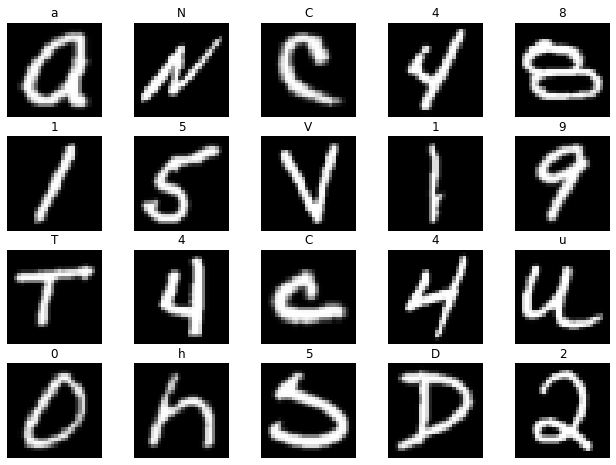

In [31]:
show_data_scheme(X_train, y_train)

3. Base line accuracy 측정 

3 - A. Lenet5

In [11]:
# basic lenet
lenet_5_model = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape=X_train[0].shape, padding='same'),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(120, kernel_size=5, strides=1, activation='tanh', padding='valid'),
    keras.layers.Flatten(),   
    keras.layers.Dense(84, activation='tanh'),
    keras.layers.Dense(62, activation='softmax')
])
lenet_5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 120)               0

In [12]:
lenet_5_model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
lenet_5_model.fit(X_train, y_train, epochs=100, batch_size = 512 ,validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100
1091/1091 [==============================] - 12s 8ms/step - loss: 0.8496 - accuracy: 0.7534 - val_loss: 0.5126 - val_accuracy: 0.8269
Epoch 2/100
1091/1091 [==============================] - 8s 7ms/step - loss: 0.4715 - accuracy: 0.8369 - val_loss: 0.4533 - val_accuracy: 0.8416
Epoch 3/100
1091/1091 [==============================] - 8s 7ms/step - loss: 0.4313 - accuracy: 0.8470 - val_loss: 0.4281 - val_accuracy: 0.8476
Epoch 4/100
1091/1091 [==============================] - 8s 7ms/step - loss: 0.4120 - accuracy: 0.8519 - val_loss: 0.4126 - val_accuracy: 0.8524
Epoch 5/100
1091/1091 [==============================] - 8s 7ms/step - loss: 0.3996 - accuracy: 0.8555 - val_loss: 0.4161 - val_accuracy: 0.8500
Epoch 6/100
1091/1091 [==============================] - 9s 8ms/step - loss: 0.3914 - accuracy: 0.8575 - val_loss: 0.4047 - val_accuracy: 0.8539
Epoch 7/100
1091/1091 [==============================] - 9s 8ms/step - loss: 0.3840 - accuracy: 0.8591 - val_loss: 0.3995 - val_a

[0.38082003593444824, 0.8605950474739075]

In [13]:
lenet_5_model.evaluate(X_test/255., y_test)
lenet_5_model.save("submit_basic_lenet.h5", save_format="h5")

3636/3636 [==============================] - 12s 3ms/step - loss: 0.3808 - accuracy: 0.8606


LeNet_5_SeLU

SeLU performs better(speed & accuracy)

In [14]:
#selu 적용 lenet

keras.backend.clear_session()

lenet_5_selu_model = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation="selu", kernel_initializer="lecun_normal", input_shape=X_train[0].shape, padding='same'),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation="selu", kernel_initializer="lecun_normal", padding='valid'),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(120, kernel_size=5, strides=1, activation="selu", kernel_initializer="lecun_normal", padding='valid'),
    keras.layers.Flatten(),   
    keras.layers.Dense(84, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(62, activation='softmax')
])

lenet_5_selu_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 120)               0

In [15]:
lenet_5_selu_model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
lenet_5_selu_model.fit(X_train, y_train, epochs=10, batch_size = 512, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/10
1091/1091 [==============================] - 10s 8ms/step - loss: 0.7730 - accuracy: 0.7651 - val_loss: 0.5087 - val_accuracy: 0.8263
Epoch 2/10
1091/1091 [==============================] - 9s 8ms/step - loss: 0.4706 - accuracy: 0.8361 - val_loss: 0.4489 - val_accuracy: 0.8415
Epoch 3/10
1091/1091 [==============================] - 10s 9ms/step - loss: 0.4322 - accuracy: 0.8459 - val_loss: 0.4284 - val_accuracy: 0.8474
Epoch 4/10
1091/1091 [==============================] - 9s 8ms/step - loss: 0.4126 - accuracy: 0.8513 - val_loss: 0.4228 - val_accuracy: 0.8486
Epoch 5/10
1091/1091 [==============================] - 9s 8ms/step - loss: 0.3985 - accuracy: 0.8555 - val_loss: 0.4044 - val_accuracy: 0.8546
Epoch 6/10
1091/1091 [==============================] - 9s 8ms/step - loss: 0.3888 - accuracy: 0.8580 - val_loss: 0.4053 - val_accuracy: 0.8518
Epoch 7/10
1091/1091 [==============================] - 9s 9ms/step - loss: 0.3810 - accuracy: 0.8599 - val_loss: 0.3949 - val_accurac

In [16]:
lenet_5_selu_model.evaluate(X_test/255., y_test)
lenet_5_selu_model.save("submit_lenet_selu.h5", save_format="h5")

3636/3636 [==============================] - 14s 4ms/step - loss: 0.3832 - accuracy: 0.8611


He Yanmei SeLU Lenet_5 model

Lowers amount of parameters = lower inference time, less stable model

In [17]:
# he yanmei selu lenet5 모델

keras.backend.clear_session()

lenet_5_improved_model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, strides=2, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train[0].shape, padding='same'),
    keras.layers.Conv2D(64, kernel_size=3, strides=2, activation="selu", kernel_initializer="lecun_normal", padding='valid'),
    keras.layers.Conv2D(32, kernel_size=1, strides=1, activation="selu", kernel_initializer="lecun_normal", padding='valid'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(62, activation='softmax')
])
lenet_5_improved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 32)          2080      
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 62)                2046      
                                                        

In [19]:
lenet_5_improved_model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_lenet5_emnist_model.h5", save_best_only=True)
lenet_5_improved_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100
1091/1091 [==============================] - 8s 7ms/step - loss: 1.9489 - accuracy: 0.4886 - val_loss: 1.1852 - val_accuracy: 0.6588
Epoch 2/100
1091/1091 [==============================] - 7s 6ms/step - loss: 1.0109 - accuracy: 0.7026 - val_loss: 0.9104 - val_accuracy: 0.7229
Epoch 3/100
1091/1091 [==============================] - 7s 6ms/step - loss: 0.8481 - accuracy: 0.7401 - val_loss: 0.8046 - val_accuracy: 0.7509
Epoch 4/100
1091/1091 [==============================] - 7s 6ms/step - loss: 0.7730 - accuracy: 0.7580 - val_loss: 0.7456 - val_accuracy: 0.7648
Epoch 5/100
1091/1091 [==============================] - 7s 6ms/step - loss: 0.7255 - accuracy: 0.7701 - val_loss: 0.7121 - val_accuracy: 0.7684
Epoch 6/100
1091/1091 [==============================] - 7s 6ms/step - loss: 0.6930 - accuracy: 0.7786 - val_loss: 0.6920 - val_accuracy: 0.7790
Epoch 7/100
1091/1091 [==============================] - 7s 6ms/step - loss: 0.6679 - accuracy: 0.7852 - val_loss: 0.6636 - val_ac

In [20]:
lenet_5_improved_model.evaluate(X_test/255., y_test)
lenet_5_improved_model.save("submit_improved_lenet5.h5", save_format="h5")

3636/3636 [==============================] - 11s 3ms/step - loss: 0.4804 - accuracy: 0.8368


3 - B. Mobilenet

In [57]:
# numpy type의 data tf.tensor type으로 변경
train_data = tf.convert_to_tensor(X_train, dtype=tf.float32)
val_data = tf.convert_to_tensor(X_val, dtype=tf.float32)
test_data = tf.convert_to_tensor(X_test, dtype=tf.float32)

In [58]:
print(train_data.shape, val_data.shape, test_data.shape)

(558345, 28, 28, 1) (139587, 28, 28, 1) (116323, 28, 28, 1)


In [59]:
# 1채널 gray 영상 3채널로 변경 -> pretrained model이 3채널 영상 사용하기 때문
final_train = tf.image.grayscale_to_rgb(train_data)
final_val = tf.image.grayscale_to_rgb(val_data)
final_test = tf.image.grayscale_to_rgb(test_data)

In [60]:
print(final_train.shape, final_val.shape, final_test.shape)

(558345, 28, 28, 3) (139587, 28, 28, 3) (116323, 28, 28, 3)


In [61]:
# mobilenet predtrained model 다운로드
mobile2 = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape = (224, 224, 3), include_top=False)

9420800/9406464 [==============================] - 0s 0us/step


In [62]:
# mobilenoet v2 파라미터 변경 baseline(test_acc : 0.8805)
# Mobile_ReLU_SGD_800_05.h5

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(62, activation = 'softmax')

optimizer = keras.optimizers.SGD(learning_rate = 0.05)

mobilev2_best_model = keras.models.Sequential()
# mobilev2_best_model.add(tf.keras.layers.Normalization( axis=-1, mean=44.412914, variance=84.77896, input_shape = (28, 28, 3)))
mobilev2_best_model.add(tf.keras.layers.Resizing(height = 224, width = 224, input_shape = (28, 28, 3)))
mobilev2_best_model.add(mobile2)
mobilev2_best_model.add(global_average_layer)
mobilev2_best_model.add(tf.keras.layers.Dense(800))
mobilev2_best_model.add(tf.keras.layers.LeakyReLU())
mobilev2_best_model.add(tf.keras.layers.Dense(100))
mobilev2_best_model.add(tf.keras.layers.LeakyReLU())
mobilev2_best_model.add(prediction_layer)

mobilev2_best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 800)               1024800   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               8

In [63]:
# 모델 compile 및 training
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
mobilev2_best_model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])
best_history = mobilev2_best_model.fit(final_train, y_train, batch_size = 64, epochs=1, validation_data=(final_val, y_val), callbacks=[early_stopping_cb])

8725/8725 [==============================] - 2681s 306ms/step - loss: 0.3957 - accuracy: 0.8582 - val_loss: 0.3483 - val_accuracy: 0.8669


In [29]:
# 모델 eval
mobilev2_best_model.evaluate(final_test/255., y_test)
mobilev2_best_model.save("submit_emnist_mobilev2.h5", save_format="h5")

3636/3636 [==============================] - 99s 27ms/step - loss: 0.3236 - accuracy: 0.8774


[0.32357779145240784, 0.8774102926254272]

4. Model 선정 및 학습

4 - A.  Lenet base - new architecture

In [52]:
keras.backend.clear_session()

lenet_5_improved_model2 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, strides=2, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train[0].shape, padding='same'),
    keras.layers.Conv2D(64, kernel_size=3, strides=2, activation="selu", kernel_initializer="lecun_normal", padding='valid'),
    keras.layers.Conv2D(32, kernel_size=1, strides=1, activation="selu", kernel_initializer="lecun_normal", padding='valid'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(62, activation='softmax')
])

lenet_5_improved_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 32)          2080      
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 62)                2046      
                                                        

In [53]:
lenet_5_improved_model2.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

lenet_5_improved_model2.fit(X_train, y_train, epochs=50, batch_size = 512, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/50
1091/1091 [==============================] - 11s 10ms/step - loss: 2.0256 - accuracy: 0.4701 - val_loss: 1.2204 - val_accuracy: 0.6576
Epoch 2/50
1091/1091 [==============================] - 8s 8ms/step - loss: 1.0497 - accuracy: 0.6941 - val_loss: 0.9359 - val_accuracy: 0.7208
Epoch 3/50
1091/1091 [==============================] - 9s 8ms/step - loss: 0.8828 - accuracy: 0.7333 - val_loss: 0.8384 - val_accuracy: 0.7441
Epoch 4/50
1091/1091 [==============================] - 9s 8ms/step - loss: 0.7968 - accuracy: 0.7542 - val_loss: 0.7702 - val_accuracy: 0.7603
Epoch 5/50
1091/1091 [==============================] - 8s 7ms/step - loss: 0.7416 - accuracy: 0.7681 - val_loss: 0.7308 - val_accuracy: 0.7681
Epoch 6/50
1091/1091 [==============================] - 9s 9ms/step - loss: 0.7023 - accuracy: 0.7774 - val_loss: 0.6843 - val_accuracy: 0.7831
Epoch 7/50
1091/1091 [==============================] - 9s 8ms/step - loss: 0.6718 - accuracy: 0.7851 - val_loss: 0.6589 - val_accurac

In [54]:
lenet_5_improved_model2.evaluate(X_test/255., y_test)
lenet_5_improved_model2.save("submit_improved_lenet5_2.h5", save_format="h5")

3636/3636 [==============================] - 13s 4ms/step - loss: 0.4861 - accuracy: 0.8358


In [11]:
# 최종 선정 모델 -> parameter 약 7만개, test accuracy 성능 양호
keras.backend.clear_session()

lenet_5_selu_dropout_model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, strides=1,  activation="selu", kernel_initializer="lecun_normal", input_shape=X_train[0].shape, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation="selu", kernel_initializer="lecun_normal", padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, kernel_size=3, strides=1, activation="selu", kernel_initializer="lecun_normal", padding='valid'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(62, activation='softmax')
])

lenet_5_selu_dropout_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 32)        18464     
                                                                 
 batch_normalization_2 (Batc  (None, 22, 22, 32)       1

In [12]:
lenet_5_selu_dropout_model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

lenet_5_selu_dropout_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100
1091/1091 [==============================] - 43s 28ms/step - loss: 1.4324 - accuracy: 0.6490 - val_loss: 0.8215 - val_accuracy: 0.7471
Epoch 2/100
1091/1091 [==============================] - 30s 27ms/step - loss: 0.6312 - accuracy: 0.8040 - val_loss: 0.6067 - val_accuracy: 0.8004
Epoch 3/100
1091/1091 [==============================] - 29s 26ms/step - loss: 0.5368 - accuracy: 0.8247 - val_loss: 0.5321 - val_accuracy: 0.8238
Epoch 4/100
1091/1091 [==============================] - 28s 26ms/step - loss: 0.4965 - accuracy: 0.8342 - val_loss: 0.5397 - val_accuracy: 0.8219
Epoch 5/100
1091/1091 [==============================] - 29s 26ms/step - loss: 0.4748 - accuracy: 0.8391 - val_loss: 0.5070 - val_accuracy: 0.8293
Epoch 6/100
1091/1091 [==============================] - 29s 26ms/step - loss: 0.4589 - accuracy: 0.8427 - val_loss: 0.4853 - val_accuracy: 0.8350
Epoch 7/100
1091/1091 [==============================] - 28s 26ms/step - loss: 0.4472 - accuracy: 0.8458 - val_loss: 0

In [13]:
lenet_5_selu_dropout_model.evaluate(X_test/255., y_test)
lenet_5_selu_dropout_model.save("submit_selu_dropout_lenet5_2.h5", save_format="h5")

3636/3636 [==============================] - 12s 3ms/step - loss: 0.3769 - accuracy: 0.8652


4 - B.  Res base - new architecture

In [64]:
# Residual block 클레스
class ResnetBlock(keras.models.Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = keras.layers.Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = keras.layers.BatchNormalization()
        self.conv_2 = keras.layers.Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = keras.layers.BatchNormalization()
        self.merge = keras.layers.Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = keras.layers.Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = keras.layers.BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

In [65]:
# optimizer 선택을 위한 함수
def select_opt(opt_name, lr):
  if opt_name == 'adam':
    optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
  elif opt_name == 'rmsprop':
    optimizer = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9)
  elif opt_name == 'sgd':
    optimizer = keras.optimizers.SGD(learning_rate = lr)
  elif opt_name == 'momentum':
    optimizer = keras.optimizers.SGD(learning_rate = lr, momentum=0.9)
  elif opt_name == 'nesterov':
    optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
  elif opt_name == 'adagrad':
    optimizer = keras.optimizers.Adagrad(learning_rate=lr)
  elif opt_name == 'adamax':
    optimizer = keras.optimizers.Adamax(learning_rate=lr, beta_1=0.9, beta_2=0.999)
  elif opt_name == 'nadam':
    optimizer = keras.optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)

  return optimizer

In [66]:
# activation 선택을 위한 함수
def select_activation(function):
  if function == 'relu':
    activation = keras.layers.ReLU()
  elif function == 'prelu':
    activation = keras.layers.PReLU()
  elif function == 'leacky_relu':
    activation = keras.layers.LeakyReLU()
  elif function == 'elu':
    activation = keras.layers.ELU()

  return activation

base resnet18 structure

In [67]:
# sequential resnet18 구조

class ResNet18(keras.models.Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = keras.layers.Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = keras.layers.BatchNormalization()
        self.pool_2 = keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = keras.layers.GlobalAveragePooling2D()
        self.flat = keras.layers.Flatten()
        self.fc = keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [68]:
resnet_model = ResNet18(62)
resnet_model.build(input_shape = (None,28,28,1))

resnet_model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
resnet_model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple          

In [69]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
resnet_history = resnet_model.fit(X_train, y_train, epochs=15, batch_size = 512, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/15
1091/1091 [==============================] - 60s 52ms/step - loss: 0.4971 - accuracy: 0.8280 - val_loss: 0.4399 - val_accuracy: 0.8458
Epoch 2/15
1091/1091 [==============================] - 56s 51ms/step - loss: 0.3761 - accuracy: 0.8608 - val_loss: 0.4070 - val_accuracy: 0.8514
Epoch 3/15
1091/1091 [==============================] - 55s 50ms/step - loss: 0.3540 - accuracy: 0.8667 - val_loss: 0.4174 - val_accuracy: 0.8446
Epoch 4/15
1091/1091 [==============================] - 54s 50ms/step - loss: 0.3398 - accuracy: 0.8712 - val_loss: 0.3900 - val_accuracy: 0.8567
Epoch 5/15
1091/1091 [==============================] - 55s 50ms/step - loss: 0.3290 - accuracy: 0.8742 - val_loss: 0.3686 - val_accuracy: 0.8627
Epoch 6/15
1091/1091 [==============================] - 54s 50ms/step - loss: 0.3205 - accuracy: 0.8765 - val_loss: 0.3552 - val_accuracy: 0.8677
Epoch 7/15
1091/1091 [==============================] - 54s 50ms/step - loss: 0.3105 - accuracy: 0.8795 - val_loss: 0.3548 -

In [72]:
resnet_model.evaluate(X_test/255., y_test)
resnet_model.save_weights('submit_resnet_base')

3636/3636 [==============================] - 31s 8ms/step - loss: 0.3478 - accuracy: 0.8713


Res_Res skip connection & Edit input kernel size

In [15]:
# skip connection을 사용하여 숫자, 대문자, 소문자로 구별한 모델 구조
class Res_5x5_v4(keras.models.Model):

    def __init__(self, num_classes, config_list, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.feature_layer_depth, self.num_layer_depth, \
        self.upper_layer_depth, self.lower_layer_depth = config_list

        self.input_ch = 32
        self.layer_ch = 32 * self.feature_layer_depth
        self.Batch_Norm_Layer = keras.layers.BatchNormalization()
        self.Global_Average_Pool_Layer = keras.layers.GlobalAveragePooling2D()
        self.Flatten_Layer = keras.layers.Flatten()

        self.Feature_Detection_Layer = self.feature_detection_layer()

        self.Number_Layer = self.number_layer()
        self.Upper_Letter_Layer = self.upper_letter_layer()
        self.Lower_Letter_Layer = self.lower_letter_layer()


        self.Prediction_Layer = keras.layers.Dense(num_classes, activation="softmax")

    def feature_detection_layer(self):
      feature_dec_layer = keras.models.Sequential()
      feature_dec_layer.add(self.Batch_Norm_Layer)
      feature_dec_layer.add(keras.layers.Conv2D(self.input_ch, (5, 5), strides=1, padding="same", kernel_initializer="he_normal"))
      feature_dec_layer.add(self.Batch_Norm_Layer)
      feature_dec_layer.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=1, padding="same"))
      feature_dec_layer.add(ResnetBlock(self.input_ch))
      feature_dec_layer.add(ResnetBlock(self.input_ch))
      
      for i in range(self.feature_layer_depth-1):
        feature_dec_layer.add(ResnetBlock(self.input_ch*(2*(i+1)), down_sample=True))
        feature_dec_layer.add(ResnetBlock(self.input_ch*(2*(i+1))))


      return feature_dec_layer

    def number_layer(self):
      num_layer = keras.models.Sequential()
      for i in range(self.num_layer_depth):
        num_layer.add(ResnetBlock(self.layer_ch*(2*(i+1)), down_sample=True))
        num_layer.add(ResnetBlock(self.layer_ch*(2*(i+1))))
      num_layer.add(self.Global_Average_Pool_Layer)
      num_layer.add(self.Flatten_Layer)

      return num_layer

    def upper_letter_layer(self):
      upper_layer = keras.models.Sequential()
      for i in range(self.upper_layer_depth):
        upper_layer.add(ResnetBlock(self.layer_ch*(2*(i+1)), down_sample=True))
        upper_layer.add(ResnetBlock(self.layer_ch*(2*(i+1))))
      upper_layer.add(self.Global_Average_Pool_Layer)
      upper_layer.add(self.Flatten_Layer)
      return upper_layer

    def lower_letter_layer(self):
      lower_layer = keras.models.Sequential()

      for i in range(self.lower_layer_depth):
        lower_layer.add(ResnetBlock(self.layer_ch*(2*(i+1)), down_sample=True))
        lower_layer.add(ResnetBlock(self.layer_ch*(2*(i+1))))
      lower_layer.add(self.Global_Average_Pool_Layer)
      lower_layer.add(self.Flatten_Layer)
      return lower_layer

In [27]:
# 하이퍼 파라미터 배열을 입력 받아 그에 맞는 모델 리턴
def select_model(config_list):
  model_class = Res_5x5_v4(62, config_list[:-2])
  dense_layer_depth = config_list[-2]
  num_nueran = config_list[-1]

  input = keras.layers.Input(shape=(28, 28, 1))

  feature_out = model_class.Feature_Detection_Layer(input)

  num_out = model_class.Number_Layer(feature_out)
  upper_out = model_class.Upper_Letter_Layer(feature_out)
  lower_out = model_class.Lower_Letter_Layer(feature_out)

  final_out = keras.layers.concatenate([num_out, upper_out, lower_out])
  for i in range(dense_layer_depth):
    final_out = tf.keras.layers.Dense(num_nueran, activation = 'relu')(final_out)

  result = model_class.Prediction_Layer(final_out)

  model = keras.models.Model(inputs=[input], outputs=[result])
  return model

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_13 (Sequential)     (None, 14, 14, 64)   171012      ['input_4[0][0]']                
                                                                                                  
 sequential_14 (Sequential)     (None, 128)          527488      ['sequential_13[0][0]']          
                                                                                                  
 sequential_15 (Sequential)     (None, 256)          2631040     ['sequential_13[0][0]']          
                                                                                            

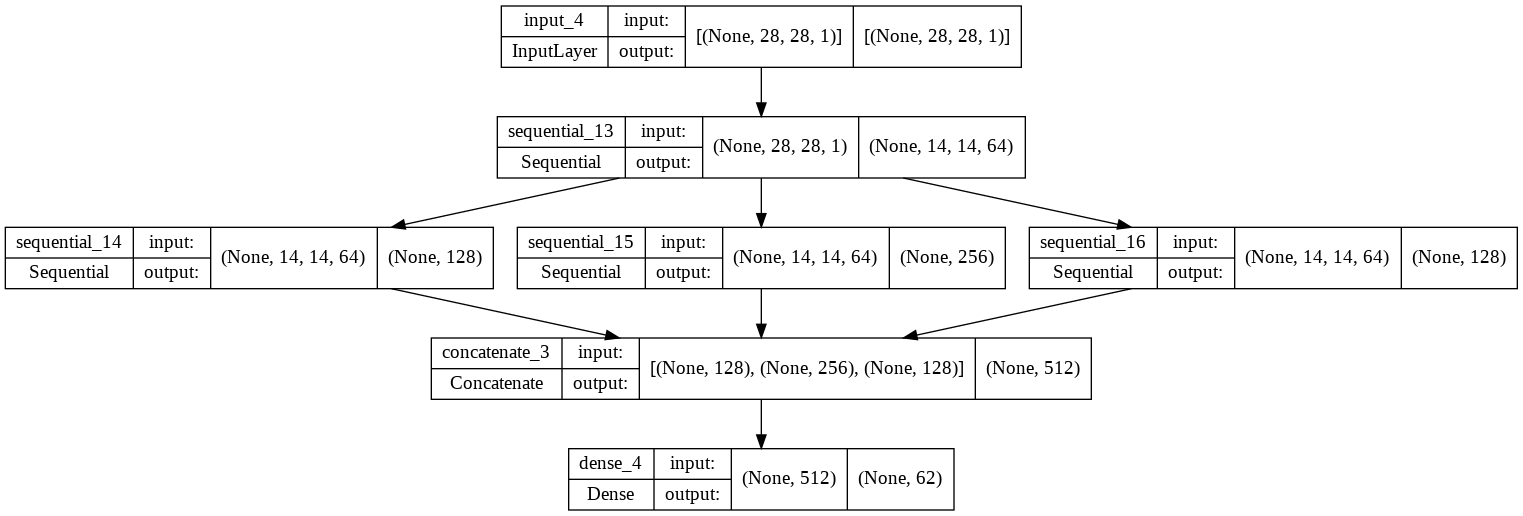

In [28]:
#[feature layer depth, 숫자 layer depth, 대문자 layer depth, 소문자 layer depth, predic layer depth, predic layer 뉴런 수]
model1_list = [2, 1, 2, 1, 0, 200]

res_res_model = select_model(model1_list)
res_res_model.summary()
keras.utils.plot_model(res_res_model, "res_dense.png", show_shapes=True)

In [29]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

learning_rate = 0.01
opt = select_opt('adagrad', learning_rate)
res_res_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
first_history = res_res_model.fit(X_train, y_train, epochs=20, batch_size = 512, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/20
1091/1091 [==============================] - 144s 128ms/step - loss: 1.0025 - accuracy: 0.7374 - val_loss: 0.5259 - val_accuracy: 0.8296
Epoch 2/20
1091/1091 [==============================] - 137s 126ms/step - loss: 0.4551 - accuracy: 0.8460 - val_loss: 0.4311 - val_accuracy: 0.8497
Epoch 3/20
1091/1091 [==============================] - 138s 127ms/step - loss: 0.4007 - accuracy: 0.8580 - val_loss: 0.3963 - val_accuracy: 0.8586
Epoch 4/20
1091/1091 [==============================] - 139s 128ms/step - loss: 0.3766 - accuracy: 0.8641 - val_loss: 0.4014 - val_accuracy: 0.8553
Epoch 5/20
1091/1091 [==============================] - 139s 128ms/step - loss: 0.3613 - accuracy: 0.8682 - val_loss: 0.3828 - val_accuracy: 0.8631
Epoch 6/20
1091/1091 [==============================] - 137s 125ms/step - loss: 0.3500 - accuracy: 0.8710 - val_loss: 0.3734 - val_accuracy: 0.8643
Epoch 7/20
1091/1091 [==============================] - 137s 125ms/step - loss: 0.3409 - accuracy: 0.8736 - val_

In [32]:
res_res_model.evaluate(X_test/255., y_test)
res_res_model.save_weights('submit_res_res')

3636/3636 [==============================] - 33s 9ms/step - loss: 0.3657 - accuracy: 0.8621


[0.3657238781452179, 0.8621252775192261]

Res + Dense layer

In [42]:
# res + res 구조에서 skip connection 부분을 dense layer로 대체
# 파라미터 수 줄이기 위해

class Res_5x5_v4(keras.models.Model):

    def __init__(self, num_classes, config_list, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)

        self.input_ch, self.activation, self.feature_layer_depth, self.num_layer_nueron, self.upper_layer_nueron, self.lower_layer_nueron = config_list


        self.Global_Average_Pool_Layer = keras.layers.GlobalAveragePooling2D()
        self.Flatten_Layer = keras.layers.Flatten()

        self.Feature_Detection_Layer = self.feature_detection_layer()

        self.Number_Layer = self.number_layer()
        self.Upper_Letter_Layer = self.upper_letter_layer()
        self.Lower_Letter_Layer = self.lower_letter_layer()


        self.Prediction_Layer = keras.layers.Dense(num_classes, activation="softmax")

    def feature_detection_layer(self):
      feature_dec_layer = keras.models.Sequential()
      # feature_dec_layer.add(keras.layers.experimental.preprocessing.RandomRotation(0.2))
      feature_dec_layer.add(keras.layers.BatchNormalization())
      feature_dec_layer.add(keras.layers.Conv2D(self.input_ch, (5, 5), strides=1, padding="same", kernel_initializer="he_normal"))
      feature_dec_layer.add(keras.layers.BatchNormalization())
      feature_dec_layer.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=1, padding="same"))
      feature_dec_layer.add(ResnetBlock(self.input_ch))
      feature_dec_layer.add(ResnetBlock(self.input_ch))
      
      for i in range(self.feature_layer_depth-1):
        feature_dec_layer.add(ResnetBlock(self.input_ch*(2*(i+1)), down_sample=True))
        feature_dec_layer.add(ResnetBlock(self.input_ch*(2*(i+1))))

      feature_dec_layer.add(self.Global_Average_Pool_Layer)
      feature_dec_layer.add(self.Flatten_Layer)


      return feature_dec_layer

    def number_layer(self):
      num_layer = keras.models.Sequential()
      for i, num_nueron in enumerate(self.num_layer_nueron):
        num_layer.add(tf.keras.layers.Dense(num_nueron))
        num_layer.add(self.select_activation(self.activation))
        num_layer.add(keras.layers.BatchNormalization())
    
      num_layer.add(tf.keras.layers.Dense(10, activation = None))

      return num_layer

    def upper_letter_layer(self):
      upper_layer = keras.models.Sequential()
      for i, num_nueron in enumerate(self.upper_layer_nueron):
        upper_layer.add(tf.keras.layers.Dense(num_nueron))
        upper_layer.add(self.select_activation(self.activation))
        upper_layer.add(keras.layers.BatchNormalization())

      upper_layer.add(tf.keras.layers.Dense(26, activation = None))
      return upper_layer

    def lower_letter_layer(self):
      lower_layer = keras.models.Sequential()

      for i, num_nueron in enumerate(self.lower_layer_nueron):
        lower_layer.add(tf.keras.layers.Dense(num_nueron))
        lower_layer.add(self.select_activation(self.activation))
        lower_layer.add(keras.layers.BatchNormalization())

      lower_layer.add(tf.keras.layers.Dense(26, activation = None))
      return lower_layer

    def select_activation(self, function):
      if function == 'relu':
        activation = keras.layers.ReLU()
      elif function == 'prelu':
        activation = keras.layers.PReLU()
      elif function == 'leacky_relu':
        activation = keras.layers.LeakyReLU()
      elif function == 'elu':
        activation = keras.layers.ELU()
      else:
        activation = keras.layers.ReLU()
      return activation

In [43]:
def select_model(config_list):
  model_class = Res_5x5_v4(64, config_list)

  input = keras.layers.Input(shape=(28, 28, 1))

  feature_out = model_class.Feature_Detection_Layer(input)

  num_out = model_class.Number_Layer(feature_out)
  upper_out = model_class.Upper_Letter_Layer(feature_out)
  lower_out = model_class.Lower_Letter_Layer(feature_out)

  final_out = keras.layers.concatenate([num_out, upper_out, lower_out])
  result = tf.nn.softmax(final_out)

  model = keras.models.Model(inputs=[input], outputs=[result])
  return model

In [44]:
def get_layer_nueron_list(channel, num_feature_layer ,num_layer, num_out_nueron):
  num_input = channel*num_feature_layer
  nueron_list = []
  interval = (num_input-num_out_nueron)//(num_layer+1)
  criterion = num_input
  for i in range(num_layer):
    criterion -= interval
    nueron_list.append(criterion)
  return nueron_list

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_17 (Sequential)     (None, 64)           171140      ['input_5[0][0]']                
                                                                                                  
 sequential_18 (Sequential)     (None, 10)           4892        ['sequential_17[0][0]']          
                                                                                                  
 sequential_19 (Sequential)     (None, 26)           3826        ['sequential_17[0][0]']          
                                                                                            

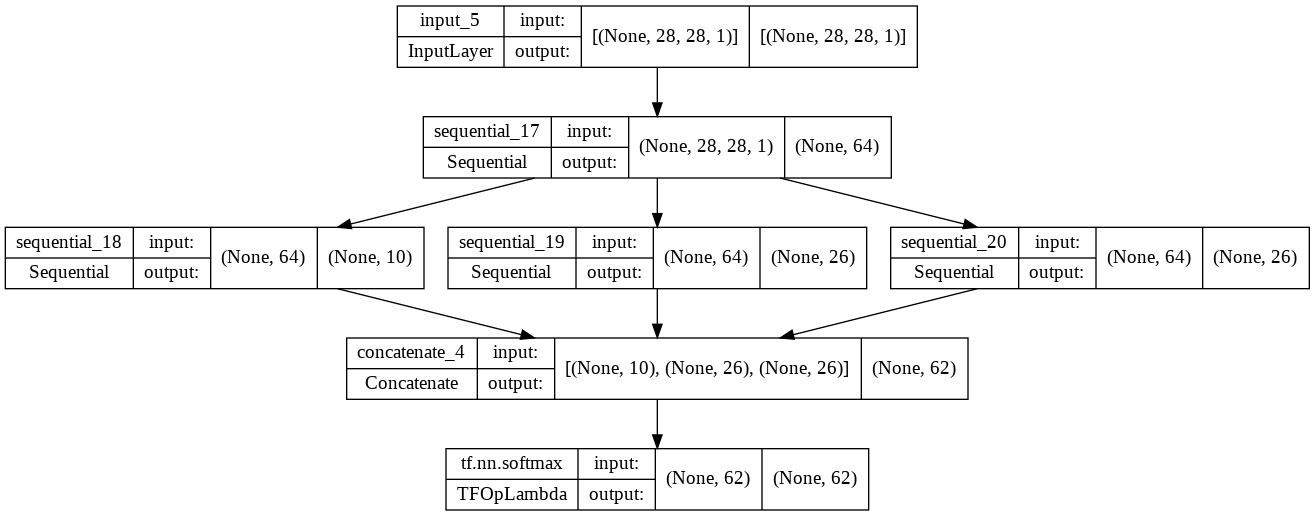

In [45]:
#[resnet channel, activation, feature detection depth, 숫자 layer 뉴런 배열, 대문자 layer 뉴런 배열, 소문자 layer 뉴런 배열]
model1_list = [32, 'relu', 2, get_layer_nueron_list(32, 2, 2, 10), get_layer_nueron_list(32, 2, 1, 16), get_layer_nueron_list(32, 2, 2, 16)] # 76.35%

res_dense_model = select_model(model1_list)
res_dense_model.summary()
keras.utils.plot_model(res_dense_model, "res_dense.png", show_shapes=True)

In [47]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

learning_rate = 0.01
opt = select_opt('momentum', learning_rate)
print(opt)


res_dense_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
res_dense_history = res_dense_model.fit(X_train, y_train, epochs=30, batch_size = 512, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/30
1091/1091 [==============================] - 80s 71ms/step - loss: 0.7576 - accuracy: 0.7891 - val_loss: 0.6185 - val_accuracy: 0.8009
Epoch 2/30
1091/1091 [==============================] - 75s 69ms/step - loss: 0.4322 - accuracy: 0.8517 - val_loss: 0.4769 - val_accuracy: 0.8364
Epoch 3/30
1091/1091 [==============================] - 75s 69ms/step - loss: 0.3979 - accuracy: 0.8592 - val_loss: 0.4715 - val_accuracy: 0.8334
Epoch 4/30
1091/1091 [==============================] - 74s 68ms/step - loss: 0.3800 - accuracy: 0.8631 - val_loss: 0.4912 - val_accuracy: 0.8299
Epoch 5/30
1091/1091 [==============================] - 74s 68ms/step - loss: 0.3689 - accuracy: 0.8662 - val_loss: 0.4461 - val_accuracy: 0.8407
Epoch 6/30
1091/1091 [==============================] - 75s 69ms/step - loss: 0.3603 - accuracy: 0.8684 - val_loss: 0.4358 - val_accuracy: 0.8500
Epoch 7/30
1091/1091 [==============================] - 74s 68ms/step - loss: 0.3533 - accuracy: 0.8701 - val_loss: 0.4686 -

In [48]:
res_dense_model.evaluate(X_test/255., y_test)
res_dense_model.save_weights('submit_res_res')

3636/3636 [==============================] - 19s 5ms/step - loss: 0.3910 - accuracy: 0.8583


auxiliary + Res + Densem

In [53]:
# auxilary output의 label을 할당해 주기 위한 part
# auxiliary output은 문자의 domain (숫자, 대문자, 소문자)를 구별하는 output 이므로 3개의 label을 가짐

domain_train_label = np.array(raw_y_train.copy())
domain_val_label = np.array(raw_y_val.copy())
domain_test_label = np.array(raw_y_test.copy())

domain_train_label[domain_train_label<10] = 0
domain_train_label[(10<=domain_train_label)&(domain_train_label<36)] = 1
domain_train_label[36<=domain_train_label] = 2

domain_val_label[domain_val_label<10] = 0
domain_val_label[(10<=domain_val_label)&(domain_val_label<36)] = 1
domain_val_label[36<=domain_val_label] = 2

domain_test_label[domain_test_label<10] = 0
domain_test_label[(10<=domain_test_label)&(domain_test_label<36)] = 1
domain_test_label[36<=domain_test_label] = 2

In [54]:
# aux output label 종류 출력
print(np.unique(domain_train_label))
print(np.unique(domain_val_label))
print(np.unique(domain_test_label))

[0 1 2]
[0 1 2]
[0 1 2]


In [56]:
# categorical cross entropy를 위한 one hot 인코딩
domain_train_label = keras.utils.to_categorical(domain_train_label)
domain_val_label = keras.utils.to_categorical(domain_val_label)
domain_test_label = keras.utils.to_categorical(domain_test_label)

In [57]:
print(domain_train_label.shape)
print(domain_val_label.shape)
print(domain_test_label.shape)

(558345, 3)
(139587, 3)
(116323, 3)


In [58]:
# res + dense 구조와 비슷하며, 추가로 aux output을 통해 domain을 구별하는 모델 추가
# 추가로 dropout + 선택적으로 average pooling 적용
class Res_5x5_v4(keras.models.Model):

    def __init__(self, num_classes, config_list, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)

        self.input_ch, self.activation, self.feature_layer_depth, self.domain_nueron, self.dropout_rate,\
        self.num_layer_nueron, self.upper_layer_nueron, self.lower_layer_nueron, self.avgpool = config_list


        self.Global_Average_Pool_Layer = keras.layers.GlobalAveragePooling2D()
        self.Flatten_Layer = keras.layers.Flatten()

        self.Feature_Detection_Layer = self.feature_detection_layer()
        
        self.Domain_Layer = self.domain_layer()
        self.Number_Layer = self.number_layer()
        self.Upper_Letter_Layer = self.upper_letter_layer()
        self.Lower_Letter_Layer = self.lower_letter_layer()


        self.Prediction_Layer = keras.layers.Dense(num_classes, activation="softmax")

    def feature_detection_layer(self):
      feature_dec_layer = keras.models.Sequential()
      feature_dec_layer.add(keras.layers.BatchNormalization())
      feature_dec_layer.add(keras.layers.Conv2D(self.input_ch, (5, 5), strides=1, padding="same", kernel_initializer="he_normal"))
      feature_dec_layer.add(keras.layers.BatchNormalization())

      if self.avgpool == 'T':
        feature_dec_layer.add(keras.layers.AvgPool2D(pool_size=2, padding = 'same'))
      else:
        feature_dec_layer.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=1, padding="same"))

      feature_dec_layer.add(ResnetBlock(self.input_ch))
      feature_dec_layer.add(ResnetBlock(self.input_ch))
      
      for i in range(self.feature_layer_depth-1):
        feature_dec_layer.add(ResnetBlock(self.input_ch*(2*(i+1)), down_sample=True))
        feature_dec_layer.add(ResnetBlock(self.input_ch*(2*(i+1))))

      feature_dec_layer.add(self.Global_Average_Pool_Layer)
      feature_dec_layer.add(self.Flatten_Layer)

      return feature_dec_layer

    def domain_layer(self):
      num_layer = keras.models.Sequential(name = "domain_out")
      for i, num_nueron in enumerate(self.domain_nueron):
        num_layer.add(tf.keras.layers.Dense(num_nueron))
        num_layer.add(self.select_activation(self.activation))
        num_layer.add(keras.layers.BatchNormalization())
      
      num_layer.add(tf.keras.layers.Dropout(self.dropout_rate))
      num_layer.add(tf.keras.layers.Dense(3, activation = 'softmax'))

      return num_layer

    def number_layer(self):
      num_layer = keras.models.Sequential(name = "number_layer")
      for i, num_nueron in enumerate(self.num_layer_nueron):
        num_layer.add(tf.keras.layers.Dense(num_nueron))
        num_layer.add(self.select_activation(self.activation))
        num_layer.add(keras.layers.BatchNormalization())

      num_layer.add(tf.keras.layers.Dropout(self.dropout_rate))
      num_layer.add(tf.keras.layers.Dense(10, activation = None))

      return num_layer

    def upper_letter_layer(self):
      upper_layer = keras.models.Sequential(name = "upper_layer")
      for i, num_nueron in enumerate(self.upper_layer_nueron):
        upper_layer.add(tf.keras.layers.Dense(num_nueron))
        upper_layer.add(self.select_activation(self.activation))
        upper_layer.add(keras.layers.BatchNormalization())

      upper_layer.add(tf.keras.layers.Dropout(self.dropout_rate))
      upper_layer.add(tf.keras.layers.Dense(26, activation = None))
      
      return upper_layer

    def lower_letter_layer(self):
      lower_layer = keras.models.Sequential(name = "lower_layer")

      for i, num_nueron in enumerate(self.lower_layer_nueron):
        lower_layer.add(tf.keras.layers.Dense(num_nueron))
        lower_layer.add(self.select_activation(self.activation))
        lower_layer.add(keras.layers.BatchNormalization())

      lower_layer.add(tf.keras.layers.Dropout(self.dropout_rate))
      lower_layer.add(tf.keras.layers.Dense(26, activation = None))

      return lower_layer

    def select_activation(self, function):
      if function == 'relu':
        activation = keras.layers.ReLU()
      elif function == 'prelu':
        activation = keras.layers.PReLU()
      elif function == 'leacky_relu':
        activation = keras.layers.LeakyReLU()
      elif function == 'elu':
        activation = keras.layers.ELU()
      else:
        activation = keras.layers.ReLU()
      return activation

In [59]:
def select_model(config_list):
  model_class = Res_5x5_v4(64, config_list)

  input = keras.layers.Input(shape=(28, 28, 1), name = "input_layer")

  feature_out = model_class.Feature_Detection_Layer(input)

  domain_result = model_class.Domain_Layer(feature_out)

  num_out = model_class.Number_Layer(feature_out)
  upper_out = model_class.Upper_Letter_Layer(feature_out)
  lower_out = model_class.Lower_Letter_Layer(feature_out)


  final_out = keras.layers.concatenate([num_out, upper_out, lower_out])
  result = tf.keras.layers.Softmax(name = 'main_out')(final_out)

  model = keras.models.Model(inputs=[input], outputs=[domain_result, result])
  return model

In [60]:
def get_layer_nueron_list(channel, num_feature_layer ,num_layer, num_out_nueron):
  num_input = channel*num_feature_layer
  nueron_list = []
  interval = (num_input-num_out_nueron)//(num_layer+1)
  criterion = num_input
  for i in range(num_layer):
    criterion -= interval
    nueron_list.append(criterion)
  return nueron_list

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_21 (Sequential)     (None, 128)          698628      ['input_layer[0][0]']            
                                                                                                  
 number_layer (Sequential)      (None, 10)           7589        ['sequential_21[0][0]']          
                                                                                                  
 upper_layer (Sequential)       (None, 26)           9725        ['sequential_21[0][0]']          
                                                                                            

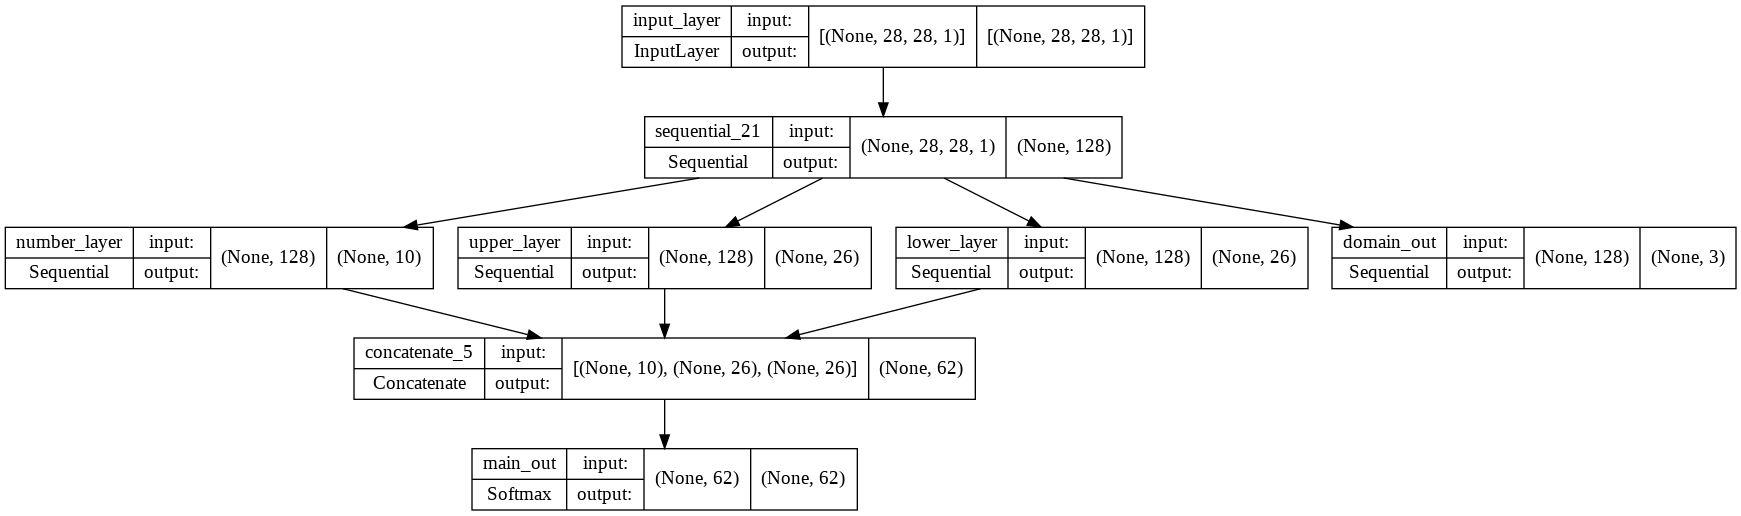

In [62]:
# [resnet channel, activation, feature layer depth, aux layer 뉴런 배열, dropout rate, 숫자 layer 뉴런 배열, 대문자 layer 뉴런 배열, 소문자 layer 뉴련 배열, avg pooling 사용 여부]
first_list = [32, 'leacky_relu', 3, [65, 34], 0.6, [53], [61], [73, 50], 'F']

aux_model = select_model(first_list)
aux_model.summary()
keras.utils.plot_model(aux_model, "aux_model.png", show_shapes=True)

In [63]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
optimizer = select_opt('nadam', 0.01)

aux_model.compile(loss=["categorical_crossentropy", "categorical_crossentropy"], loss_weights=[0.3, 0.7],
                  optimizer=optimizer,
                  metrics=["accuracy",]
                  )
aux_history = aux_model.fit(X_train, [domain_train_label, y_train], epochs=50, batch_size = 512,
                     validation_data=(X_val, [domain_val_label, y_val]), callbacks=[early_stopping_cb])

Epoch 1/50
1091/1091 [==============================] - 118s 98ms/step - loss: 0.6167 - domain_out_loss: 0.4221 - main_out_loss: 0.7001 - domain_out_accuracy: 0.8299 - main_out_accuracy: 0.7964 - val_loss: 0.4405 - val_domain_out_loss: 0.3543 - val_main_out_loss: 0.4774 - val_domain_out_accuracy: 0.8561 - val_main_out_accuracy: 0.8366
Epoch 2/50
1091/1091 [==============================] - 106s 97ms/step - loss: 0.4323 - domain_out_loss: 0.3268 - main_out_loss: 0.4775 - domain_out_accuracy: 0.8688 - main_out_accuracy: 0.8463 - val_loss: 0.4091 - val_domain_out_loss: 0.3351 - val_main_out_loss: 0.4408 - val_domain_out_accuracy: 0.8628 - val_main_out_accuracy: 0.8555
Epoch 3/50
1091/1091 [==============================] - 106s 97ms/step - loss: 0.4006 - domain_out_loss: 0.3121 - main_out_loss: 0.4385 - domain_out_accuracy: 0.8744 - main_out_accuracy: 0.8547 - val_loss: 0.3731 - val_domain_out_loss: 0.3250 - val_main_out_loss: 0.3938 - val_domain_out_accuracy: 0.8641 - val_main_out_accura

In [66]:
aux_model.evaluate(X_test/255., [domain_test_label, y_test])
aux_model.save_weights('aux_model')

3636/3636 [==============================] - 30s 8ms/step - loss: 0.3392 - domain_out_loss: 0.3123 - main_out_loss: 0.3507 - domain_out_accuracy: 0.8752 - main_out_accuracy: 0.8760


4 - C.  VGG – pre-trained

In [26]:
# vgg net1

inputs = Input(shape = (28,28,1))
x = Conv2D (filters =32, kernel_size =3, padding ='same', activation='relu')(inputs)
x = Conv2D (filters =32, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 2nd Conv Block
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 3rd Conv block  
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x) 
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x) 
x= BatchNormalization()(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 4th Conv block
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 5th Conv block
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# Fully connected layers  
x = Flatten()(x)
x= BatchNormalization()(x)
x = Dense(units = 4096, activation ='relu')(x)
x = Dense(units = 4096, activation ='relu')(x)
output = Dense(units = 62, activation ='softmax')(x)
# creating the model

VGG_model = Model (inputs=inputs, outputs =output)
VGG_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 64)        1849

In [30]:
VGG_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.005), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
VGG_model.fit(X_train, y_train, batch_size = 512, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/20
1091/1091 [==============================] - 67s 60ms/step - loss: 1.3157 - accuracy: 0.6543 - val_loss: 0.5427 - val_accuracy: 0.8205
Epoch 2/20
1091/1091 [==============================] - 66s 61ms/step - loss: 0.4620 - accuracy: 0.8404 - val_loss: 0.4753 - val_accuracy: 0.8400
Epoch 3/20
1091/1091 [==============================] - 64s 58ms/step - loss: 0.4210 - accuracy: 0.8524 - val_loss: 0.4660 - val_accuracy: 0.8420
Epoch 4/20
1091/1091 [==============================] - 62s 57ms/step - loss: 0.4010 - accuracy: 0.8576 - val_loss: 0.4431 - val_accuracy: 0.8486
Epoch 5/20
1091/1091 [==============================] - 63s 57ms/step - loss: 0.3853 - accuracy: 0.8620 - val_loss: 0.4289 - val_accuracy: 0.8514
Epoch 6/20
1091/1091 [==============================] - 62s 57ms/step - loss: 0.3746 - accuracy: 0.8647 - val_loss: 0.4023 - val_accuracy: 0.8604
Epoch 7/20
1091/1091 [==============================] - 63s 58ms/step - loss: 0.3660 - accuracy: 0.8668 - val_loss: 0.3955 -

In [31]:
VGG_model.evaluate(X_test/255., y_test)
VGG_model.save("submit_VGG_1.h5", save_format="h5")

3636/3636 [==============================] - 21s 6ms/step - loss: 0.3648 - accuracy: 0.8729


VGG 2

In [32]:
# vgg net 2
inputs = Input(shape = (28,28,1))
x = Conv2D (filters =32, kernel_size =3, padding ='same', activation='relu')(inputs)
x = Conv2D (filters =32, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 2nd Conv Block
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 3rd Conv block  
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x) 
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.3)(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 4th Conv block
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 5th Conv block
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# Fully connected layers  
x = Flatten()(x)
x= BatchNormalization()(x)
x = Dense(units = 4096, activation ='relu')(x)
x = Dense(units = 4096, activation ='relu')(x)
output = Dense(units = 62, activation ='softmax')(x)
# creating the model

VGG_model_2 = Model (inputs=inputs, outputs =output)
VGG_model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_68 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_69 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_27 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 14, 14, 64)        1849

In [33]:
VGG_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.005), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_new_emnist_model.h5", save_best_only=True)
VGG_model_2.fit(X_train, y_train, batch_size = 512, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100
1091/1091 [==============================] - 67s 60ms/step - loss: 1.4546 - accuracy: 0.6152 - val_loss: 0.8856 - val_accuracy: 0.7440
Epoch 2/100
1091/1091 [==============================] - 64s 59ms/step - loss: 0.4860 - accuracy: 0.8329 - val_loss: 0.5768 - val_accuracy: 0.8144
Epoch 3/100
1091/1091 [==============================] - 64s 59ms/step - loss: 0.4380 - accuracy: 0.8475 - val_loss: 1.0587 - val_accuracy: 0.7073
Epoch 4/100
1091/1091 [==============================] - 64s 59ms/step - loss: 0.4175 - accuracy: 0.8530 - val_loss: 0.4533 - val_accuracy: 0.8494
Epoch 5/100
1091/1091 [==============================] - 64s 59ms/step - loss: 0.3978 - accuracy: 0.8587 - val_loss: 0.4461 - val_accuracy: 0.8467
Epoch 6/100
1091/1091 [==============================] - 64s 59ms/step - loss: 0.3884 - accuracy: 0.8617 - val_loss: 0.3921 - val_accuracy: 0.8602
Epoch 7/100
1091/1091 [==============================] - 65s 59ms/step - loss: 0.3775 - accuracy: 0.8644 - val_loss: 0

In [34]:
VGG_model_2.evaluate(X_test/255., y_test)
VGG_model_2.save("submit_VGG_2.h5", save_format="h5")

3636/3636 [==============================] - 21s 6ms/step - loss: 0.3463 - accuracy: 0.8759


VGG 3

In [37]:
# vgg net3
inputs = Input(shape = (28,28,1))
x = Conv2D (filters =32, kernel_size =3, padding ='same', activation='relu')(inputs)
x = Conv2D (filters =32, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 2nd Conv Block
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 3rd Conv block  
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x) 
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x) 
x= BatchNormalization()(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 4th Conv block
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 5th Conv block
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.3)(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# Fully connected layers  
x = Flatten()(x)
x= BatchNormalization()(x)
x = Dense(units = 4096, activation ='relu')(x)
x = Dense(units = 4096, activation ='relu')(x)
output = Dense(units = 62, activation ='softmax')(x)
# creating the model

VGG_model_3 = Model (inputs=inputs, outputs =output)
VGG_model_3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_94 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_95 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_39 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 14, 14, 64)        1849

In [38]:
VGG_model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_new_emnist_model.h5", save_best_only=True)
  
VGG_model_3.fit(X_train, y_train, batch_size = 512, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/20
1091/1091 [==============================] - 66s 58ms/step - loss: 2.1634 - accuracy: 0.5414 - val_loss: 1.0383 - val_accuracy: 0.6780
Epoch 2/20
1091/1091 [==============================] - 62s 57ms/step - loss: 0.5930 - accuracy: 0.8037 - val_loss: 4.9309 - val_accuracy: 0.7093
Epoch 3/20
1091/1091 [==============================] - 63s 57ms/step - loss: 0.4802 - accuracy: 0.8350 - val_loss: 0.5805 - val_accuracy: 0.8080
Epoch 4/20
1091/1091 [==============================] - 62s 57ms/step - loss: 0.4833 - accuracy: 0.8355 - val_loss: 0.5081 - val_accuracy: 0.8210
Epoch 5/20
1091/1091 [==============================] - 62s 57ms/step - loss: 0.4254 - accuracy: 0.8514 - val_loss: 0.4681 - val_accuracy: 0.8416
Epoch 6/20
1091/1091 [==============================] - 62s 57ms/step - loss: 0.4091 - accuracy: 0.8561 - val_loss: 0.4487 - val_accuracy: 0.8446
Epoch 7/20
1091/1091 [==============================] - 62s 57ms/step - loss: 0.3994 - accuracy: 0.8588 - val_loss: 0.4118 -

In [39]:
VGG_model_3.evaluate(X_test/255., y_test)
VGG_model_3.save("submit_VGG_3.h5", save_format="h5")

3636/3636 [==============================] - 20s 6ms/step - loss: 0.3903 - accuracy: 0.8627


VGG 4

In [40]:
## vgg net4
inputs = Input(shape = (28,28,1))
x = Conv2D (filters =32, kernel_size =3, padding ='same', activation='relu')(inputs)
x = Conv2D (filters =32, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 2nd Conv Block
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 3rd Conv block  
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x) 
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x) 
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 4th Conv block
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 5th Conv block
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# Fully connected layers  
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(units = 4096, activation ='relu')(x)
x = BatchNormalization()(x)
x = Dense(units = 4096, activation ='relu')(x)
x = BatchNormalization()(x)
output = Dense(units = 62, activation ='softmax')(x)
# creating the model

VGG_model_4 = Model (inputs=inputs, outputs =output)
VGG_model_4.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_107 (Conv2D)         (None, 28, 28, 32)        320       
                                                                 
 conv2d_108 (Conv2D)         (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_109 (Conv2D)         (None, 14, 14, 64)        18496     
                                                                 
 conv2d_110 (Conv2D)         (None, 14, 14, 64)        36928     
                                                           

In [41]:
VGG_model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.005), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_new_model.h5", save_best_only=True)
  
VGG_model_4.fit(X_train, y_train, batch_size = 512, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/20
1091/1091 [==============================] - 65s 58ms/step - loss: 1.5075 - accuracy: 0.6348 - val_loss: 0.8307 - val_accuracy: 0.7226
Epoch 2/20
1091/1091 [==============================] - 62s 56ms/step - loss: 0.6304 - accuracy: 0.7990 - val_loss: 1.0865 - val_accuracy: 0.6127
Epoch 3/20
1091/1091 [==============================] - 62s 57ms/step - loss: 0.5218 - accuracy: 0.8263 - val_loss: 0.7969 - val_accuracy: 0.7412
Epoch 4/20
1091/1091 [==============================] - 62s 56ms/step - loss: 0.4922 - accuracy: 0.8374 - val_loss: 0.5843 - val_accuracy: 0.8008
Epoch 5/20
1091/1091 [==============================] - 62s 57ms/step - loss: 0.4560 - accuracy: 0.8457 - val_loss: 0.4853 - val_accuracy: 0.8290
Epoch 6/20
1091/1091 [==============================] - 62s 57ms/step - loss: 0.4367 - accuracy: 0.8505 - val_loss: 0.4892 - val_accuracy: 0.8283
Epoch 7/20
1091/1091 [==============================] - 62s 56ms/step - loss: 0.4192 - accuracy: 0.8549 - val_loss: 0.6481 -

In [42]:
VGG_model_4.evaluate(X_test/255., y_test)
VGG_model_4.save("submit_VGG_4.h5", save_format="h5")

3636/3636 [==============================] - 21s 6ms/step - loss: 0.4809 - accuracy: 0.8302


4 - D.  Efficient net - pre-trained

In [94]:
# efficientent
# pretrained model이 3 채널 영상을 사용하여, rgb 채널 데이터 사용
IMG_SHAPE = (224, 224, 3)
model0 = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE, include_top=False, weights="imagenet", classifier_activation="softmax")

model0.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (Zero

In [95]:
#make new model _eff_model
tf.keras.utils.plot_model(model0) # to draw and visualize

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(62, activation = 'softmax')

eff_model = keras.models.Sequential()
eff_model.add(tf.keras.layers.Normalization( axis=-1, mean=0.016425587, variance=0.03171295, input_shape = (28, 28, 3)))
eff_model.add(tf.keras.layers.Resizing(height = 224, width = 224))
eff_model.add(model0)
eff_model.add(global_average_layer)
eff_model.add(tf.keras.layers.Dense(500, activation = 'relu'))
eff_model.add(prediction_layer)


eff_model.summary() # to see the list of layers and parameters


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 28, 28, 3)        0         
 ion)                                                            
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_26 (Dense)            (None, 500)               640500    
                                                                 
 dense_25 (Dense)            (None, 62)              

In [102]:
eff_model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


eff_model_history = eff_model.fit(final_train, y_train, epochs = 1, validation_data=(final_val, y_val),callbacks=[early_stopping_cb])

17449/17449 [==============================] - 3950s 226ms/step - loss: 0.4118 - accuracy: 0.8519 - val_loss: 0.6371 - val_accuracy: 0.7884


In [103]:
eff_model.evaluate(final_test/255., y_test)
# eff_model.save("eff_model.h5", save_format="h5")

3636/3636 [==============================] - 143s 39ms/step - loss: 0.6314 - accuracy: 0.7887


[0.6314153075218201, 0.7886574268341064]

Test on hand_made data

In [83]:
# handmade emnist data 로드
hand_made_csv = pd.read_csv("./our_handmade_dataset.csv", header=None)
hand_data, hand_label = convert_data_csv_to_numpy(hand_made_csv, sorting = False)
raw_hand_data = hand_data.copy()
hand_made_csv = []

PreProcessing

In [84]:
# 기존의 emnist 데이터의 형식에 맞추기 위한 pre processing 함수
def pre_processing(data, mean):
  # images = np.zeros((data.shape[0], 20, 20))
  for i in range(data.shape[0]):
    image = data[i]
    first_norm = 255/np.max(image)
    image = (image*first_norm).astype(np.uint8)
    image[:2, :], image[-2:, :], image[:, :2], image[:,-2:] = 0, 0, 0, 0

    _, binary_image = cv2.threshold(image.astype(np.uint8), 0, 255, cv2.THRESH_OTSU)
    min_max_list = np.where(binary_image==255)
    x_min, x_max = np.min(min_max_list[1]), np.max(min_max_list[1])
    y_min, y_max = np.min(min_max_list[0]), np.max(min_max_list[0])

    if abs(x_max - x_min) >abs(y_max - y_min):
      add_sub_factor = (abs(x_max - x_min) - abs(y_max - y_min))//2
      y_min = max(0, y_min-add_sub_factor-1)
      y_max = min(27, y_max+add_sub_factor+1)

    if abs(y_max - y_min) > abs(x_max - x_min):
      add_sub_factor = (abs(y_max - y_min)-abs(x_max - x_min))//2
      x_min = max(0, x_min-add_sub_factor-1)
      x_max = min(27, x_max+add_sub_factor+1)

    data[i] = np.pad(cv2.resize(image.astype(np.uint8)[y_min:y_max, x_min:x_max], (20, 20)), ((4, 4), (4, 4)), 'constant', constant_values = 0)
    second_norm = 255/np.max(data[i])
    data[i] = (data[i]*second_norm).astype(np.uint8)

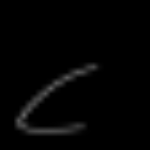

before processing 



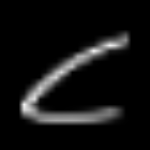

after processing


In [85]:
# 전처리 전 후 이미지 비교
hand_data = hand_data.reshape(-1, 28, 28)
index = 500

t_data = hand_data[index].copy()
cv2_imshow(cv2.resize(t_data.astype(np.uint8).T, (150, 150)))
print("before processing \n")

pre_processing(t_data.reshape(1, 28, 28), None)
cv2_imshow(cv2.resize(t_data.astype(np.uint8).T, (150, 150)))
print("after processing")

In [86]:
# 전처리 함수 적용 및 테스트 데이터 처리
pre_processing(hand_data, None)

raw_hand_label = hand_label.copy()

hand_data = tf.convert_to_tensor(hand_data.reshape(-1, 28, 28, 1), dtype=tf.float32)
raw_hand_data = tf.convert_to_tensor(raw_hand_data.reshape(-1, 28, 28, 1), dtype=tf.float32)
hand_label = tf.keras.utils.to_categorical(hand_label)

print(hand_data.shape, hand_label.shape)

(2480, 28, 28, 1) (2480, 62)


In [87]:
final_hand_data = tf.image.grayscale_to_rgb(hand_data)
final_raw_hand_data = tf.image.grayscale_to_rgb(raw_hand_data)
print(final_hand_data.shape)

(2480, 28, 28, 3)


In [88]:
# aux resnet test를 위한 데이터 처리
domain_hand_label = np.array(raw_hand_label.copy())

domain_hand_label[domain_hand_label<10] = 0
domain_hand_label[(10<=domain_hand_label)&(domain_hand_label<36)] = 1
domain_hand_label[36<=domain_hand_label] = 2

In [89]:
print(np.unique(domain_hand_label))

domain_hand_label = keras.utils.to_categorical(domain_hand_label)
print(domain_hand_label.shape)

[0 1 2]
(2480, 3)


전처리 적용 전 후 eval 결과 비교

In [106]:
# 전처리 전
print('<Before Pre-Processing>')

# base line
print("basic Lenet :")
lenet_5_model.evaluate(raw_hand_data/255., hand_label)
print("MobileNetV2 :")
mobilev2_best_model.evaluate(final_raw_hand_data/255., hand_label)

# custom
print('final_Lenet : ')
lenet_5_selu_dropout_model.evaluate(raw_hand_data/255., hand_label)

print('Res_Res : ')
res_res_model.evaluate(raw_hand_data/255., hand_label)
print('Res_Dense : ')
res_dense_model.evaluate(raw_hand_data/255., hand_label)
print('Auxiliary_Res_Dense : ')
aux_model.evaluate(raw_hand_data/255., [domain_hand_label, hand_label])

print("VGG :")
VGG_model_2.evaluate(raw_hand_data/255., hand_label)
print('Efficient Net : ')
eff_model.evaluate(final_raw_hand_data/255., hand_label)


# 전처리 후
print('\n\n<After Pre-Processing>')

# base line
print("basic Lenet :")
lenet_5_model.evaluate(hand_data/255., hand_label)
print("MobileNetV2 :")
mobilev2_best_model.evaluate(final_hand_data/255., hand_label)

# custom
print('final_Lenet : ')
lenet_5_selu_dropout_model.evaluate(hand_data/255., hand_label)

print('Res_Res : ')
res_res_model.evaluate(hand_data/255., hand_label)
print('Res_Dense : ')
res_dense_model.evaluate(hand_data/255., hand_label)
print('Auxiliary_Res_Dense : ')
aux_model.evaluate(hand_data/255., [domain_hand_label, hand_label])

print("VGG :")
VGG_model_2.evaluate(hand_data/255., hand_label)
print('Efficient : ')
eff_model.evaluate(final_hand_data/255., hand_label)

print()

<Before Pre-Processing>
basic Lenet :
78/78 [==============================] - 0s 3ms/step - loss: 4.3756 - accuracy: 0.2355
MobileNetV2 :
78/78 [==============================] - 3s 27ms/step - loss: 1.2280 - accuracy: 0.6210
final_Lenet : 
78/78 [==============================] - 0s 3ms/step - loss: 4.4725 - accuracy: 0.2310
Res_Res : 
78/78 [==============================] - 1s 9ms/step - loss: 3.7603 - accuracy: 0.2855
Res_Dense : 
78/78 [==============================] - 0s 5ms/step - loss: 5.0705 - accuracy: 0.1819
Auxiliary_Res_Dense : 
78/78 [==============================] - 1s 7ms/step - loss: 1.5496 - domain_out_loss: 0.8866 - main_out_loss: 1.8338 - domain_out_accuracy: 0.5923 - main_out_accuracy: 0.4851
VGG :
78/78 [==============================] - 1s 5ms/step - loss: 3.2034 - accuracy: 0.4032
Efficient Net : 
78/78 [==============================] - 3s 40ms/step - loss: 5.0015 - accuracy: 0.1798


<After Pre-Processing>
basic Lenet :
78/78 [==============================

data augmentation

In [43]:
import random

# augmentation class
class data_augment:
  def __init__(self, image, label):
    self.image = image.astype(np.uint8)
    self.label = label
    self.k_size = random.choice([3, 5, 7])
    _, self.binary = cv2.threshold(self.image, 10, 255, cv2.THRESH_BINARY)
    # _, self.binary = cv2.threshold(self.image, 0, 255, cv2.THRESH_OTSU)

  def recrop_image(self, img= None, new_bin=None):
    if img is None:
      img = self.image
    if new_bin is None:
      new_bin = self.binary


    min_max_list = np.where(new_bin>240)
    x_min, x_max = np.min(min_max_list[1]), np.max(min_max_list[1])
    y_min, y_max = np.min(min_max_list[0]), np.max(min_max_list[0])

    if abs(x_max - x_min) >abs(y_max - y_min):
      add_sub_factor = (abs(x_max - x_min) - abs(y_max - y_min))//2
      y_min = max(0, y_min-add_sub_factor-1)
      y_max = min(27, y_max+add_sub_factor+1)

    if abs(y_max - y_min) > abs(x_max - x_min):
      add_sub_factor = (abs(y_max - y_min)-abs(x_max - x_min))//2
      x_min = max(0, x_min-add_sub_factor-1)
      x_max = min(27, x_max+add_sub_factor+1)

    dst = np.pad(cv2.resize(img.astype(np.uint8)[y_min:y_max, x_min:x_max], (20, 20)), ((4, 4), (4, 4)), 'constant', constant_values = 0)
    second_norm = 255/np.max(dst)

    return dst

  def pixel_britness_change(self, max_value):
    dst = self.image.copy()
    dst = (dst*(max_value/255)).astype(np.uint8)
    return dst

  def image_erode(self, img = None):
    if img is None:
      img = self.image
    
    dst = cv2.resize(img.copy(),(224, 224))
    _, binary = cv2.threshold(dst, 0, 255, cv2.THRESH_OTSU)

    erode_result = cv2.erode(binary, np.ones((self.k_size, self.k_size)))

    dst[erode_result==0] = 0
    dst = cv2.resize(dst,(28, 28))
    dst = self.recrop_image(dst, cv2.resize(erode_result, (28, 28)))
    return dst

  def image_dilation(self, img = None):
    if img is None:
      img = self.image

    dst = cv2.resize(img.copy(),(224, 224))
    _, binary = cv2.threshold(dst, 0, 255, cv2.THRESH_OTSU)

    dilation_result = cv2.dilate(binary, np.ones((self.k_size, self.k_size)))

    dst[dilation_result!=dst] = dilation_result[dst!=dilation_result]
    dst = cv2.resize(dst,(28, 28))
    dst = self.recrop_image(dst, cv2.resize(dilation_result, (28, 28)))

    return dst

  def image_open(self):
    erode = self.image_erode()
    dst = self.image_dilation(img = erode)
    return dst

  def image_close(self):
    dil = self.image_dilation()
    dst = self.image_erode(img = dil)
    return dst

  def select_agu_strategy(self, i):
    if i % 4 == 0:
      dst = self.image_erode()
    elif i % 4 == 1:
      dst = self.image_dilation()
    elif i % 4 == 2:
      dst = self.image_open()
    else:
      dst = self.image_close()
  
    return dst

선 두께 변화

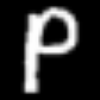

origin


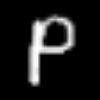

erode


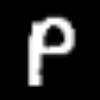

dilation


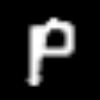

open


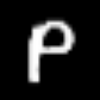

close


In [44]:
idx = 4876
aug_list = ['erode','dilation','open','close']

test_for_aug = X_train[idx, :, :, 0].copy()*255
cv2_imshow(cv2.resize(test_for_aug, (100, 100)).T)
print('origin')

for i in range(4):
  Aug = data_augment(test_for_aug, 0)
  dst = Aug.select_agu_strategy(i)
  cv2_imshow(cv2.resize(dst, (100, 100)).T)
  print(aug_list[i])

회전 및 zoom

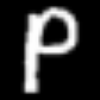

origin


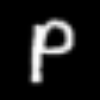

zoom_out


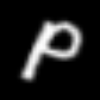

rotation


In [56]:
index = 4876
teest = X_train[index].copy()*255
cv2_imshow(cv2.resize(teest, (100, 100)).T)
print('origin')



center_rate = random.choice([0.9, 0.85, 0.95])
aug1 = cv2.resize(np.array(tf.image.central_crop(teest, central_fraction = center_rate)), (28, 28))
Aug1 = data_augment(aug1, 0)
result1 = Aug1.recrop_image().reshape(28, 28, 1)
cv2_imshow(cv2.resize(result1, (100, 100)).T)
print('zoom_out')

aug = cv2.resize(np.array(tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, fill_mode='constant', fill_value =0)(teest)), (28, 28))
Aug = data_augment(aug, 0)
result = Aug.recrop_image().reshape(28, 28, 1)
cv2_imshow(cv2.resize(result, (100, 100)).T)
print('rotation')
